## Example 1: Second-order reaction, well-mixed simulation 

example script: ex1_reac.py

Model checking:
Warnings:
SC in cyt is only ever present on the RHS of reactions.
Model checking:
Warnings:
SC in cyt is only ever present on the RHS of reactions.


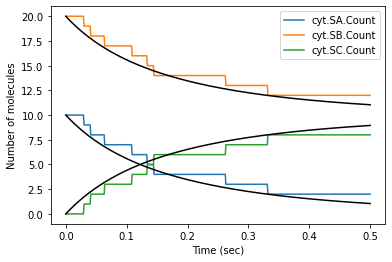

In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Example 1: Second-order reaction, well-mixed simulation 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import the new steps interface
import steps.interface

# Import biochemical model module
from steps.model import *

# Create model container
mdl = Model()

# Create reaction manager
r = ReactionManager()

# Using this model, declare species and reactions
with mdl:
    # Create chemical species
    SA, SB, SC  = Species.Create()

    # Create reaction set container
    vsys = VolumeSystem.Create()

    with vsys:
        # Create reaction
        # SA + SB - > SC with rate 200 /uM.s
        SA + SB >r[1]> SC
        r[1].K = 200e6

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import geometry module
from steps.geom import *

# Create well-mixed geometry container
wmgeom = Geometry()

# Using this geometry, declare compartments
with wmgeom:
    # Create cytosol compartment, associate it with vsys, give volume in m^3
    cyt = Compartment.Create(vsys, vol=1e-18)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import random number generator module
from steps.rng import *

# Create random number generator, with buffer size as 256 and starting seed 899
rng = RNG('mt19937', 256, 899)

# Could use time to get random seed
# import time
# rng = RNG('mt19937', 256, int(time.time()))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import simulation and data saving modules
from steps.sim import *
from steps.saving import *

# Create well-mixed stochastic simulation object
sim_wm = Simulation('Wmdirect', mdl, wmgeom, rng)

# Create a result selector associated to sim_wm
rs = ResultSelector(sim_wm)

# Specify which values should be saved, here all species counts in compartment "cyt"
counts_wm = rs.cyt.ALL(Species).Count

# Save these values every 0.001s
sim_wm.toSave(counts_wm, dt=0.001)

# Signalize the start of a new run
sim_wm.newRun()

# Initialize the number of 'SA' molecules to 10
sim_wm.cyt.SA.Count = 10

# Or you can set the concentration (M), as for 'SB'
sim_wm.cyt.SB.Conc = 3.32e-08

# Run simulation until 0.5s, data is recorded automatically
sim_wm.run(0.5)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create well-mixed deterministic solver
sim_rk4 = Simulation('Wmrk4', mdl, wmgeom, rng)

# Set the integration time-step (s)
sim_rk4.setRk4DT(0.00001)

# Declare values to be saved for the deterministic solver
rs = ResultSelector(sim_rk4)
counts_rk4 = rs.cyt.ALL(Species).Count
sim_rk4.toSave(counts_rk4, dt=0.001)

# Repeat the simulation process for the deterministic solver
sim_rk4.newRun()
sim_rk4.cyt.SA.Count = 10
sim_rk4.cyt.SB.Conc = 3.32e-08
sim_rk4.run(0.5)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import matplotlib via pylab
from pylab import *

# Use Matlpotlib functions to plot data from both simulations
# Note that we access data from run 0
plot(counts_wm.time[0], counts_wm.data[0])
plot(counts_rk4.time[0], counts_rk4.data[0], color='black')

ylabel('Number of molecules')
xlabel('Time (sec)')
legend(counts_wm.labels)
show()

## Example 2: Surface reactions: IP3 receptor model 

### 1. Biochemical model and geometry
example script: ex2_ip3model.py

In [2]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Example 2: Surface reactions: IP3 receptor model 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

import steps.interface

from steps.model import *
from steps.geom import *

###############################################################################

def getModel():

    # Create model container object
    mdl = Model()
    r = ReactionManager()
    with mdl:
        # Chemical species
        Ca, IP3 = Species.Create() # Calcium and IP3
        
        # Receptor state objects
        R     = Species.Create() # IP3 receptor in 'naive' state
        RIP3  = Species.Create() # bound IP3 
        Ropen = Species.Create() # bound IP3 and Ca (open)
        RCa   = Species.Create() # 1 bound Ca to inactivation site
        R2Ca  = Species.Create() # 2 bound Ca to inactivation sites
        R3Ca  = Species.Create() # 3 bound Ca to inactivation sites
        R4Ca  = Species.Create() # 4 bound Ca to inactivation sites
        
        surfsys = SurfaceSystem.Create()

        with surfsys:
            # The binding reactions:
            R.s + IP3.o   <r[1]> RIP3.s
            RIP3.s + Ca.o <r[2]> Ropen.s
            R.s + Ca.o    <r[3]> RCa.s
            RCa.s + Ca.o  <r[4]> R2Ca.s
            R2Ca.s + Ca.o <r[5]> R3Ca.s
            R3Ca.s + Ca.o <r[6]> R4Ca.s

            # The reaction constants
            r[1].K = 1000000000.0, 25800.0
            r[2].K = 8000000000.0, 2000.0
            r[3].K = 8889000.0, 5.0
            r[4].K = 20000000.0, 10.0
            r[5].K = 40000000.0, 15.0
            r[6].K = 60000000.0, 20.0

            # Ca ions passing through open IP3R channel
            Ca.i + Ropen.s <r[1]> Ropen.s + Ca.o
            # Corresponds to Ca input ~ 20000/ms for open receptor
            r[1].K = 8000000.0, 8000000.0

    # return model container object
    return mdl

###############################################################################

def getGeom(mdl):

    geom = Geometry()
    with geom:
        # Create cytosol compartment
        cyt = Compartment.Create()
        # Assign volume to cytosol 
        cyt.Vol = 1e-19
        
        # Create ER compartment
        ER = Compartment.Create()
        # Assign volume to ER 
        ER.Vol = 2e-20
        
        # Create the ER membrane and associate it with a surface system
        ERmemb = Patch.Create(ER, cyt, mdl.surfsys)

    # return geometry container object
    return geom

###############################################################################

### 2. Simulation
example script: ex2_sim.py

Model checking:
No errors were found
Ran 100 sim iterations


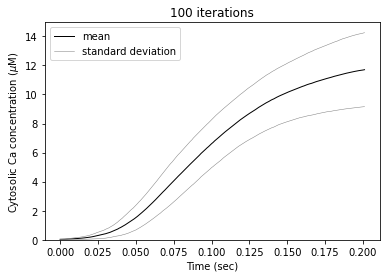

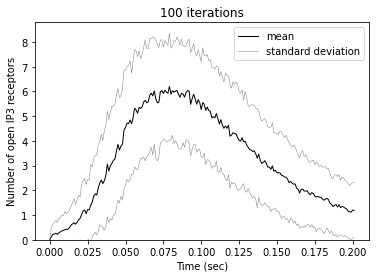

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Example 2: Surface reactions: IP3 receptor model 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

import steps.interface

from steps.rng import *
from steps.sim import *
from steps.saving import *

from matplotlib import pyplot as plt
import numpy  as np

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Simulation control variables
NITER = 100
T_END = 0.201
DT = 0.001

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import model
mdl = getModel()

# Import geometry 
geom = getGeom(mdl)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create random number generator
r = RNG('mt19937', 512, 654)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create well-mixed solver object
sim = Simulation('Wmdirect', mdl, geom, r)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

rs = ResultSelector(sim)

results = rs.cyt.Ca.Conc * 1e6 << rs.ERmemb.Ropen.Count

sim.toSave(results, dt=DT)

# Run the simulation
for i in range(NITER):
    
    # Start a new run
    sim.newRun()
    
    # Set initial conditions
    sim.cyt.Ca.Conc = 3.30657e-08
    sim.cyt.IP3.Conc = 2.5e-06
    sim.ER.Ca.Conc = 0.00015
    sim.ERmemb.R.Count = 16
    
    # Clamp ER calcium to fixed concentration
    sim.ER.Ca.Clamped = True

    # Run the simulation
    sim.run(T_END)

print(f'Ran {NITER} sim iterations')

# Numpy array manipulation
mean_res = np.mean(results.data, 0)
std_res = np.std(results.data, 0)
res_std1 = mean_res + std_res
res_std2 = mean_res - std_res

tpnts = results.time[0]

# Plot Ca concentration
plt.plot(tpnts, mean_res[:, 0], color = 'black', linewidth = 1.0, label = 'mean')
plt.plot(tpnts, res_std1[:, 0], color = 'gray', linewidth = 0.5, label = 'standard deviation')
plt.plot(tpnts, res_std2[:, 0], color = 'gray', linewidth = 0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Cytosolic Ca concentration ($\mu$M)')
plt.title(f'{NITER} iterations')
plt.ylim(0)
plt.legend()
plt.show()

# Plot open IP3 receptors
plt.plot(tpnts, mean_res[:, 1], color = 'black', linewidth = 1.0, label = 'mean')
plt.plot(tpnts, res_std1[:, 1], color = 'gray', linewidth = 0.5, label = 'standard deviation')
plt.plot(tpnts, res_std2[:, 1], color = 'gray', linewidth = 0.5)
plt.xlabel('Time (sec)')
plt.ylabel('Number of open IP3 receptors')
plt.title(f'{NITER} iterations')
plt.ylim(0)
plt.legend()
plt.show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Let's run the simulation:

## Example 3: Unbounded diffusion 
example script: ex3_diff.py

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Example 3: Unbounded diffusion 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

import steps.interface

from steps.model import *
from steps.geom import *
from steps.sim import *
from steps.saving import *
from steps.rng import *

from matplotlib import pyplot as plt
import numpy as np

########################################################################

# The Abaqus file to import
MESHFILE = 'meshes/sp_10r_3875'
# The number of iterations to run 
NITER = 10
# The data collection time increment (s)
DT = 0.001
# The simulation endtime (s)
INT = 0.101

# The number of molecules to be injected into the centre
NINJECT = 10000    

# The number of tetrahedral elements to sample data from. 
SAMPLE = 2000    

# The diffusion constant for our diffusing species (m^2/s)
DCST= 20.0e-12

########################################################################

def gen_model():         
    mdl = Model()
    with mdl:
        SA = Species.Create()
        vsys = VolumeSystem.Create()
        with vsys:
            Diffusion(SA, DCST)
    return mdl

########################################################################

def gen_geom(meshPath, mdl):

    print("Loading mesh...")
    mesh = TetMesh.LoadAbaqus(meshPath, 1e-6)
    print("Mesh Loaded")

    with mesh:
        # Create a compartment containing all tetrahedron
        cyto = Compartment.Create(mesh.tets, mdl.vsys)

        print("Finding tetrahedron samples...")
        # List to hold tetrahedrons
        tets = TetList()

        # Fetch the central tetrahedron
        ctet = mesh.tets[0, 0, 0]
        tets.append(ctet)
        tets += ctet.neighbs

        # Find the maximum and minimum coordinates of the mesh
        bmin = mesh.bbox.min
        bmax = mesh.bbox.max

        # Run a loop until we have stored all tet indices we require
        while len(tets) < SAMPLE:
            # Pick a random position within the bounding box
            pos = bmin + (bmax - bmin) * np.random.random(3)
            if pos in mesh.tets:
                tets.append(mesh.tets[pos])

        # Find the radial distance of the tetrahedrons to mesh center:
        tetrads = np.array([np.linalg.norm(tet.center)*1e6 for tet in tets])

        print("Tetrahedron samples found")

    return mesh, tets, tetrads

########################################################################

model = gen_model()
mesh, tets, tetrads = gen_geom(MESHFILE, model)

rng = RNG('mt19937', 512, 2903)

sim = Simulation('Tetexact', model, mesh, rng)

rs = ResultSelector(sim)

AConc = rs.TETS(tets).SA.Conc

sim.toSave(AConc, dt=DT)

for i in range(NITER):
    sim.newRun()
    print("Running iteration", i)
    # Inject all molecules into the central tet:
    sim.TET(0, 0, 0).SA.Count = NINJECT
    sim.run(INT)

########################################################################

def plotres(tidx, tpnts, res_mean, tetrads):
    if tidx >= len(tpnts):
        raise ValueError('Time index is out of range.')
    t = tpnts[tidx]

    plt.scatter(tetrads, res_mean[tidx,:], s=2)
    plt.xlabel('Radial distance of tetrahedron ($\mu$m)')            
    plt.ylabel('Concentration in tetrahedron ($\mu$M)')
    plt.title(f'Unbounded diffusion. Time: {t}s')

    plotAnalytical(t)

    plt.xlim(0.0, max(tetrads))
    plt.ylim(0.0)
    plt.show()

########################################################################

def plotAnalytical(t):     
    segs = 100     
    anlytconc = np.zeros((segs))     
    radialds = np.zeros((segs))     
    maxrad = 0.0     
    for i in tetrads:         
        if (i > maxrad): maxrad = i     
    maxrad *= 1e-6     
    intervals = maxrad/segs     
    rad = 0.0     
    for i in range((segs)):         
        # Find the conc from analytical solution, and convert to mol/L         
        anlytconc[i]=1.0e3*(1/6.022e23)* \
                ((NINJECT/((4*np.pi*DCST*t) ** 1.5))* \
                (np.exp((-1.0*(rad*rad))/(4*DCST*t))))         
        radialds[i] = rad*1e6         
        rad += intervals     
    plt.plot(radialds, anlytconc, color = 'red')

########################################################################


Loading mesh...
Mesh Loaded
Finding tetrahedron samples...
Tetrahedron samples found
Model checking:
No errors were found
Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9


Let's run the simulation and plot the results

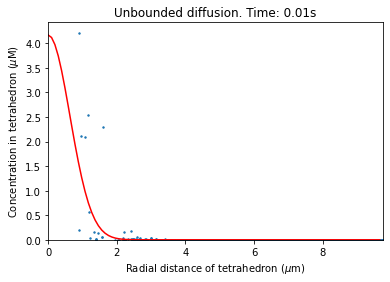

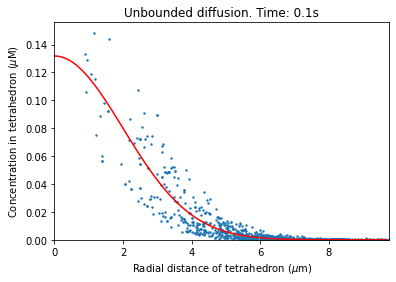

In [5]:
tpnts = AConc.time[0]
res_mean = np.mean(AConc.data, axis=0)*1e6

plotres(10, tpnts, res_mean, tetrads)
plotres(100, tpnts, res_mean, tetrads)

## Example 4: Hodgkin-Huxley Action Potential propagation model
example script: ex4_HH.py

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

# Example 4: Hodgkin-Huxley Action Potential propagation model

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # IMPORTS # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import steps.interface

from steps.model import *
from steps.geom import *
from steps.sim import *
from steps.saving import *
from steps.rng import *

import numpy as np
import os
import math

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# # # # # # # # # # # # # # # # # # PARAMETERS  # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # CHANNELS  # # # # # # # # # # # # # # # # # #

# Potassium conductance = 0.036 S/cm2
# Sodium conductance = 0.120 S/cm2

# Potassium single-channel conductance
K_G = 20.0e-12 # Siemens

# Potassium channel density
K_ro = 18.0e12 # per square meter

# Potassium reversal potential
K_rev = -77e-3 # volts

# Sodium single-channel conductance
Na_G = 20.0e-12 # Siemens

# Sodium channel density
Na_ro = 60.0e12 # per square meter

# Sodium reversal potential
Na_rev = 50e-3 # volts

# Leak single-channel conductance
L_G = 0.3e-12 # Siemens

# Leak density
L_ro = 10.0e12 # per square meter

# Leak reveral potential
leak_rev = -54.4e-3 # volts


# A table of potassium channel population factors: 
# n0, n1, n2, n3, n4
K_facs = [ 0.21768, 0.40513, 0.28093, 0.08647, 0.00979 ]

# A table of sodium channel population factors
# m0h0, m1h0, m2h0, m3h0, m0h1, m1h1, m2h1, m3h1:
Na_facs = [[0.34412, 0.05733, 0.00327, 6.0e-05],
           [0.50558, 0.08504, 0.00449, 0.00010]]

# # # # # # # # # # # # # # # # # # RATE FUNCTION # # # # # # # # # # # # # # # #

def HHRateFunction(A, B, C, D, F, H, V, abs_tol=1e-13):
    num = A + B * V
    denom = C + H * math.exp((V + D) / F)
    if math.isclose(num, 0, abs_tol=abs_tol) and math.isclose(denom, 0, abs_tol=abs_tol):
        return F * B / (H * math.exp((V + D) / F))
    else:
        return num / denom

# # # # # # # # # # # # # # # # # # MESH  # # # # # # # # # # # # # # # # # # # # 

meshfile_ab = 'meshes/axon_cube_L1000um_D443nm_equiv0.5_19087tets.inp'

# # # # # # # # # # # # # # # SIMULATION CONTROLS # # # # # # # # # # # # # # # #

# Temperature for gating kinetics
celsius = 20.0

# Current injection
Iclamp = 50.0e-12 #	amps

# Voltage range for gating kinetics in Volts
Vrange = [-100.0e-3, 50e-3, 1e-4]

# The simulation dt
DT_sim = 1.0e-4 # seconds

# The time until which the simulation should be run
ENDT = 4.0e-3

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # BIOCHEMICAL MODEL # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

model = Model()

r = ReactionManager()

with model:
    ssys = SurfaceSystem.Create()

    #  Potassium channel
    Ko, Kc = SubUnitState.Create()
    KSU = SubUnit.Create([Ko, Kc])
    VGKC = Channel.Create([KSU]*4)

    # Sodium channel
    Na_mo, Na_mc, Na_hi, Na_ha = SubUnitState.Create()
    NamSU, NahSU = SubUnit.Create(
        [Na_mo, Na_mc],
        [Na_hi, Na_ha]
    )
    VGNaC = Channel.Create([NamSU, NamSU, NamSU, NahSU])

    # Leak channel
    lsus = SubUnitState.Create()
    Leak = Channel.Create([lsus])

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

    # Hodgkin-Huxley gating kinetics

    # Temperature dependence
    thi = math.pow(3.0, ((celsius-6.3)/10.0))

    _a_n = VDepRate(lambda V: thi * 1e3 * HHRateFunction(-0.55, -0.01, -1, 55, -10, 1, V*1e3), vrange=Vrange)
    _b_n = VDepRate(lambda V: thi * 1e3 * HHRateFunction(1, 0, 0, 65, 80, 8, V*1e3), vrange=Vrange)
    
    _a_m = VDepRate(lambda V: thi * 1e3 * HHRateFunction(-4, -0.1, -1, 40, -10, 1, V*1e3), vrange=Vrange)
    _b_m = VDepRate(lambda V: thi * 1e3 * HHRateFunction(1, 0, 0, 65, 18, 0.25, V*1e3), vrange=Vrange)

    _a_h = VDepRate(lambda V: thi * 1e3 * HHRateFunction(1, 0, 0, 65, 20, 1 / 0.07, V*1e3), vrange=Vrange)
    _b_h = VDepRate(lambda V: thi * 1e3 * HHRateFunction(1, 0, 1, 35, -10, 1, V*1e3), vrange=Vrange)

    with ssys:

        with VGKC[...]:
            Kc.s <r[1]> Ko.s
            r[1].K = _a_n, _b_n

        with VGNaC[...]:
            Na_hi.s <r[1]> Na_ha.s
            r[1].K = _a_h, _b_h
            
            Na_mc.s <r[1]> Na_mo.s
            r[1].K = _a_m, _b_m

        # Create ohmic current objects
        VGKC_I = OhmicCurr.Create(VGKC[Ko, Ko, Ko, Ko], K_G, K_rev)
        VGNaC_I = OhmicCurr.Create(VGNaC[Na_mo, Na_mo, Na_mo, Na_ha], Na_G, Na_rev)
        Leak_I = OhmicCurr.Create(Leak[lsus], L_G, leak_rev)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # TETRAHEDRAL MESH  # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

mesh = TetMesh.LoadAbaqus(meshfile_ab, scale=1e-6)

# # # # # # # # # # # # # # # MESH MANIPULATION # # # # # # # # # # # # # # # # #

facetris = TriList([tri for tri in mesh.tris if tri.center.z == mesh.bbox.min.z])
injverts = facetris.verts

print("Found ", len(injverts), "I_inject vertices")
print("Found ", len(facetris), "triangles on bottom face")

memb_tris = mesh.surface - facetris

# The points along (z) axis at which to record potential
pot_pos = np.arange(mesh.bbox.min.z, mesh.bbox.max.z, 10e-6)
pot_tet = [mesh.tets[(0, 0, z)] for z in pot_pos]

# # # # # # # # # # # # # # # GEOMETRY OBJECTS  # # # # # # # # # # # # # # # # #

with mesh:
    # Create cytosol compartment
    cyto = Compartment.Create(mesh.tets)

    # Create the patch and associate with surface system ssys
    patch = Patch.Create(memb_tris, cyto, None, ssys)

    # Create the membrane across which the potential will be solved
    membrane = Membrane.Create([patch], opt_method = 1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # SIMULATION  # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

rng = RNG('mt19937', 512, 1234)

sim = Simulation('Tetexact', model, mesh, rng, True)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

rs = ResultSelector(sim)

NaCurrs = rs.TRIS(memb_tris).VGNaC_I.I
KCurrs = rs.TRIS(memb_tris).VGKC_I.I
CellPot = rs.TETS(pot_tet).V

NaCurrs.metaData['trizpos'] = [tri.center.z for tri in memb_tris]
KCurrs.metaData['trizpos'] = [tri.center.z for tri in memb_tris]
NaCurrs.metaData['triarea'] = [tri.Area for tri in memb_tris]
KCurrs.metaData['triarea'] = [tri.Area for tri in memb_tris]
CellPot.metaData['tetzpos'] = pot_pos

sim.toSave(NaCurrs, KCurrs, CellPot, dt=DT_sim)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

sim.newRun()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Inject channels
surfarea = sim.patch.Area

for state in VGNaC:
    prop = Na_facs[state.Count(Na_ha)][state.Count(Na_mo)]
    sim.patch.VGNaC[state].Count = Na_ro * surfarea * prop

for state in VGKC:
    prop = K_facs[state.Count(Ko)]
    sim.patch.VGKC[state].Count = K_ro * surfarea * prop

sim.patch.Leak[lsus].Count = L_ro * surfarea

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Set some simulation variables:

# Set dt for membrane potential calculation to 0.01ms
sim.EfieldDT = 1.0e-5

# Initialize potential to -65mV
sim.membrane.Potential = -65e-3

# Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
sim.membrane.Capac = 1.0e-2

# Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
sim.membrane.VolRes = 1.0

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Set the current clamp

sim.VERTS(injverts).IClamp = Iclamp/len(injverts)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Run the simulation
sim.run(ENDT)

Found  4 I_inject vertices
Found  2 triangles on bottom face
Model checking:
No errors were found


Run the simulation:

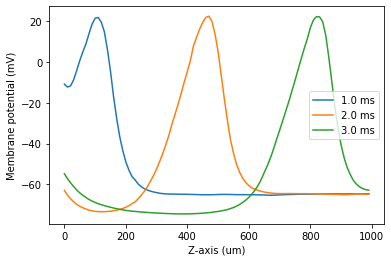

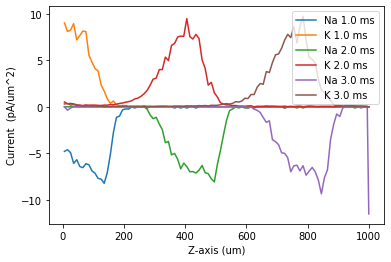

In [7]:
from matplotlib import pyplot as plt

NBINS = 100

def getTIdx(saver, t):
    return min(enumerate(saver.time[0]), key=lambda v: abs(v[1] - t))[0]

def plotPotential(t):
    tidx = getTIdx(CellPot, t)
    plt.plot(
        CellPot.metaData['tetzpos'] * 1e6, 
        CellPot.data[0, tidx, :] * 1e3, 
        label=f'{CellPot.time[0, tidx]*1e3} ms'
    )

def plotCurrents(t):
    tidx = getTIdx(NaCurrs, t)
    for results, currName in zip([NaCurrs, KCurrs], ['Na', 'K']):
        data = results.data[0, tidx, :] * 1e12
        pos = results.metaData['trizpos'] * 1e6
        areas = results.metaData['triarea'] * 1e12
        bins = np.histogram_bin_edges(pos, NBINS)
        dig = np.digitize(pos, bins)
        # Ignore empty bins
        with np.errstate(invalid='ignore'):
            meanData = np.bincount(dig, weights=data) / np.bincount(dig, weights=areas)
            meanPos  = np.bincount(dig, weights=pos) / np.bincount(dig)
        plt.plot(meanPos, meanData, label=f'{currName} {results.time[0, tidx]*1e3} ms')

plotPotential(1e-3)
plotPotential(2e-3)
plotPotential(3e-3)
plt.xlabel('Z-axis (um)')
plt.ylabel('Membrane potential (mV)')
plt.legend()
plt.show()
    
plotCurrents(1e-3)
plotCurrents(2e-3)
plotCurrents(3e-3)
plt.xlabel('Z-axis (um)')
plt.ylabel('Current  (pA/um^2)')
plt.legend()
plt.show()